# Category features
This notebook we will explore the category features. Before we start, one needs to figure out what is the definition of category features?
* Any features that can __divide__ the whole samples into different levels or categories, in this sense, any features with values of type _integer_ and _string_ are category features.
* The next question will be how to explore those category features? We can do boxplot with price and the count of each category.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
training = "../../data/train.csv"
test = "../../data/test.csv"

In [3]:
df_train = pd.read_csv(training)
df_test = pd.read_csv(test)

In [4]:
df_train = df_train[df_train.GrLivArea<4000]

In [5]:
def simple_count(column, size):
    fig = plt.figure(figsize=size)
    plt.title("Number of occurences by category "+ column)
    plt.xlabel("Number of occurences")
    plt.ylabel(column)
    df_train[column].value_counts(sort=False,dropna=False).plot.barh()

In [6]:
def simple_violin(column, size):
    fig = plt.figure(figsize=size)
    sns.violinplot(x=column, y="SalePrice", data=df_train, inner="quartile")

## OverallQual
A very important feature.

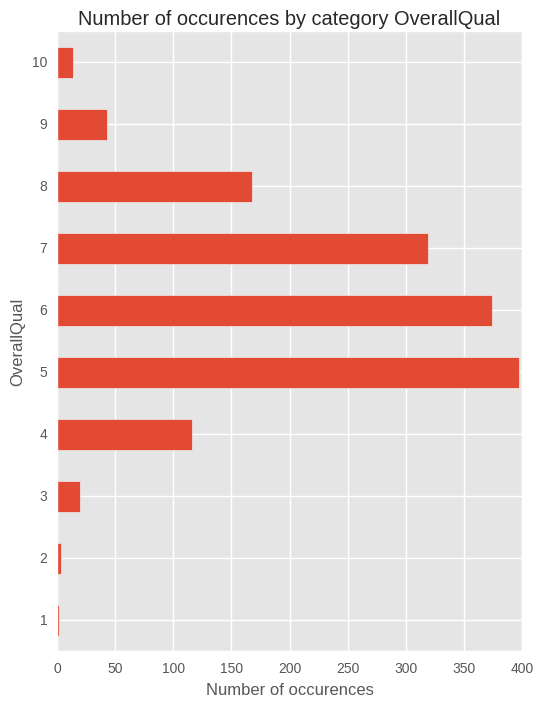

In [7]:
simple_count("OverallQual",(6,8))

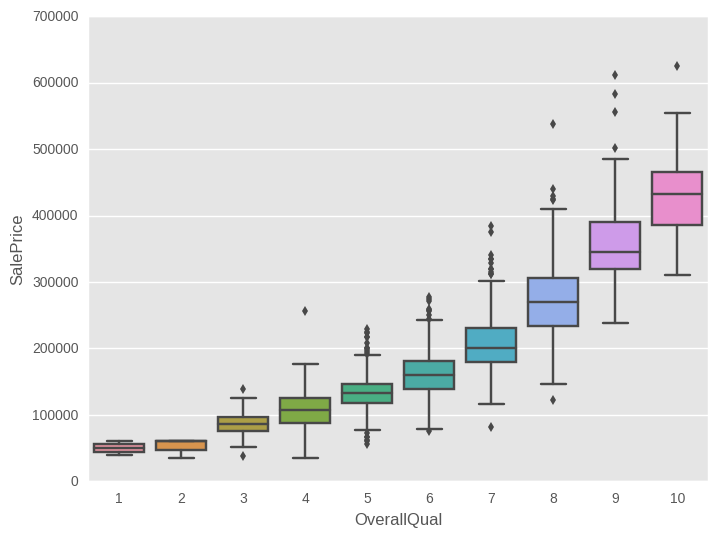

In [8]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)

Most houses have the rates in the range of `5-7`, and it has strong correlation with the price.

## GarageCars
Another important feature that describes the size of the garage in terms of the number of cars.

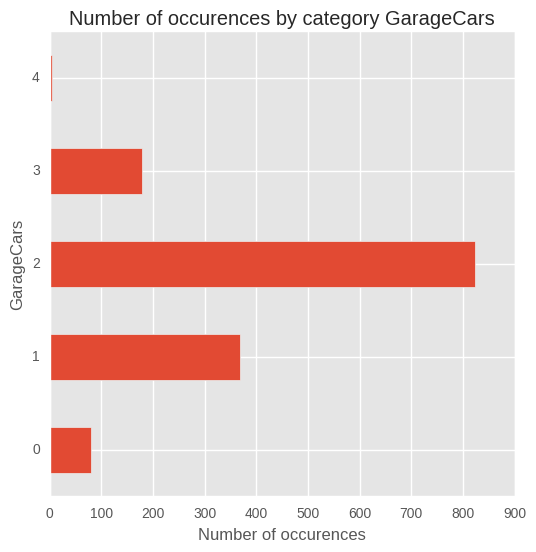

In [9]:
simple_count("GarageCars", (6,6))

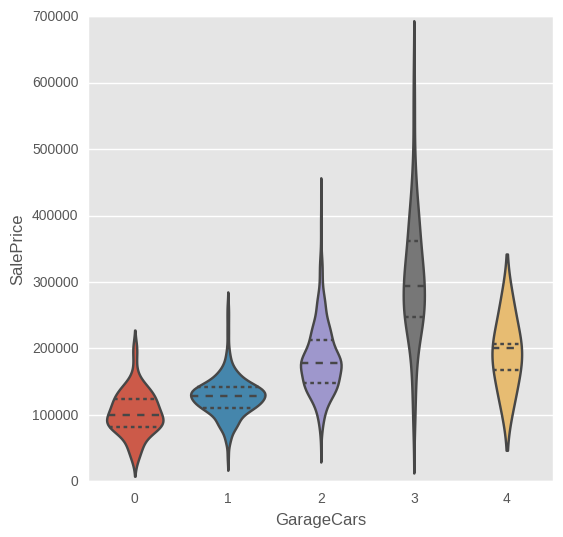

In [10]:
simple_violin("GarageCars", (6,6))

It looks like majority of the houses have the garage that can hold 2 cars, there may be some outliers when the house have the 3-car garage.

## FullBath
This one describes the number of full bathrooms above the ground. 

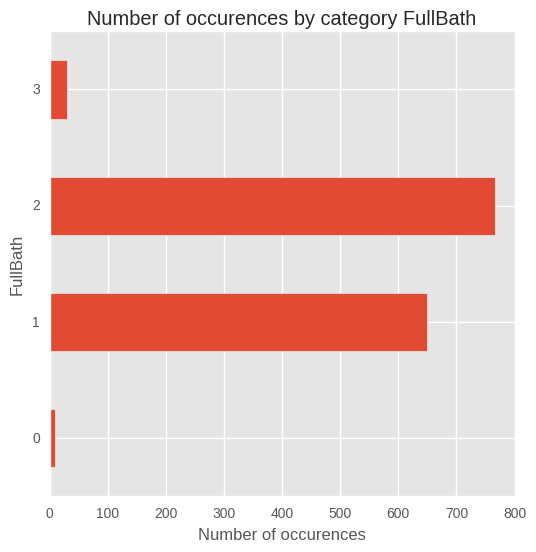

In [11]:
simple_count("FullBath", (6,6))

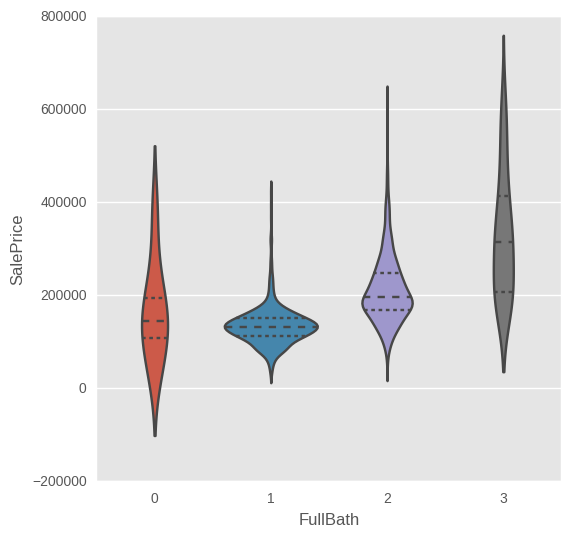

In [12]:
simple_violin("FullBath", (6,6))

Most houses have 1 or 2 bathrooms above ground, it needs to add with other bathrooms features.

## HalfBath
Half bathrooms are bathrooms without bathtubs. This feature compute the number of Half bathrooms above ground.

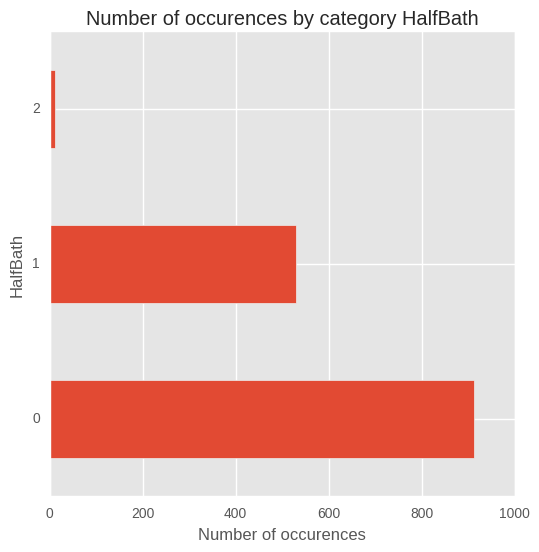

In [13]:
simple_count("HalfBath", (6,6))

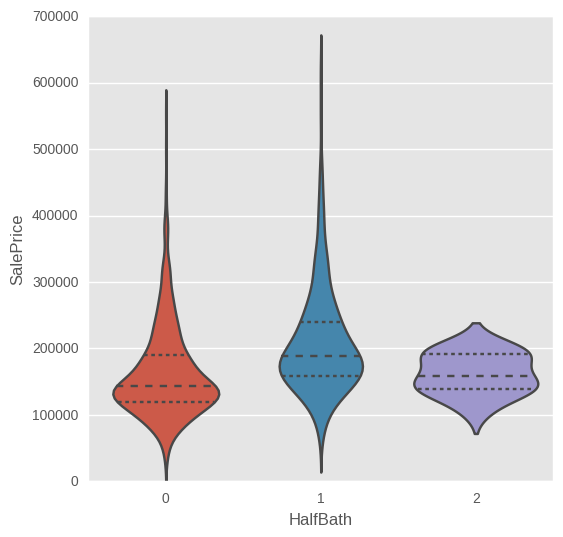

In [14]:
simple_violin("HalfBath", (6,6))

Most houses don't have Half bathrooms above the ground. Even though this feature is not highly correlated with price, we can try to add all half bathrooms together, then drop this one.

## BsmtFullBath
The number of Full bathrooms in the basement. And bathrooms in the basement in the basement is not that important than those above ground. 

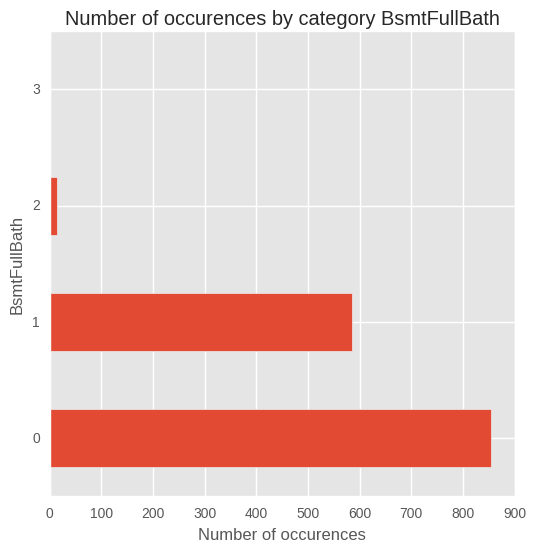

In [15]:
simple_count("BsmtFullBath", (6,6))

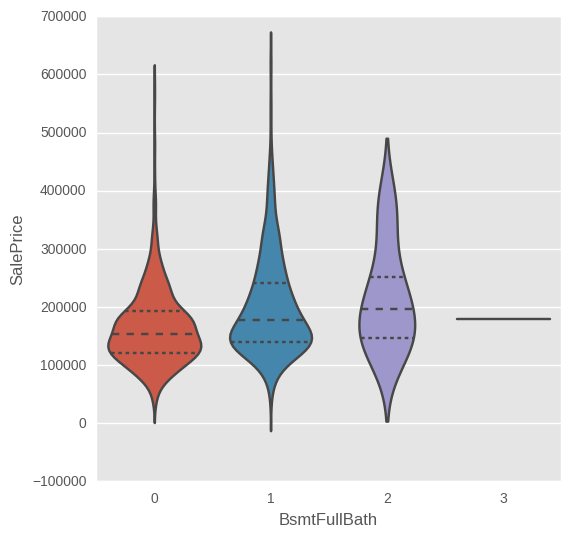

In [16]:
simple_violin("BsmtFullBath", (6,6))

## BsmtHalfBath
This one is the number of Half bathrooms in the basement.

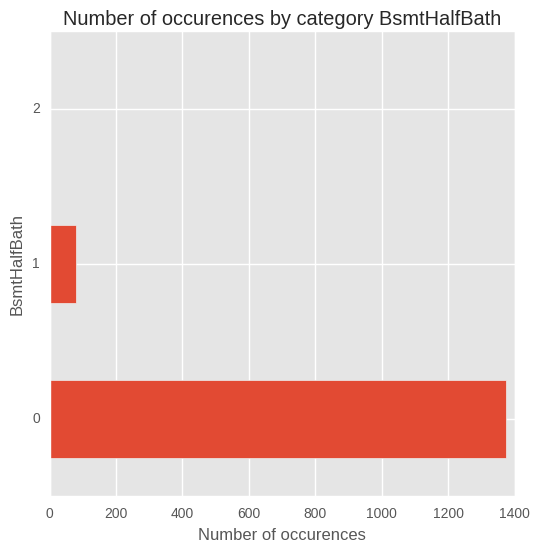

In [17]:
simple_count("BsmtHalfBath", (6,6))

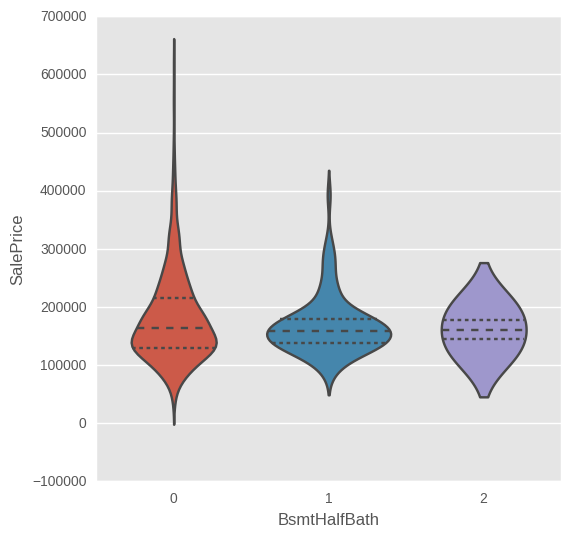

In [18]:
simple_violin("BsmtHalfBath", (6,6))

We can drop this feature after adding other half baths and bathrooms features

Overall, in BathRoom features, we can add together half baths and baths seperatedly to have two features each for total number of bathrooms, and half baths. Then another feature to compute the total number of half and full bathrooms. 

## TotRmsAbvGrd
The number rooms above ground without any bathrooms.

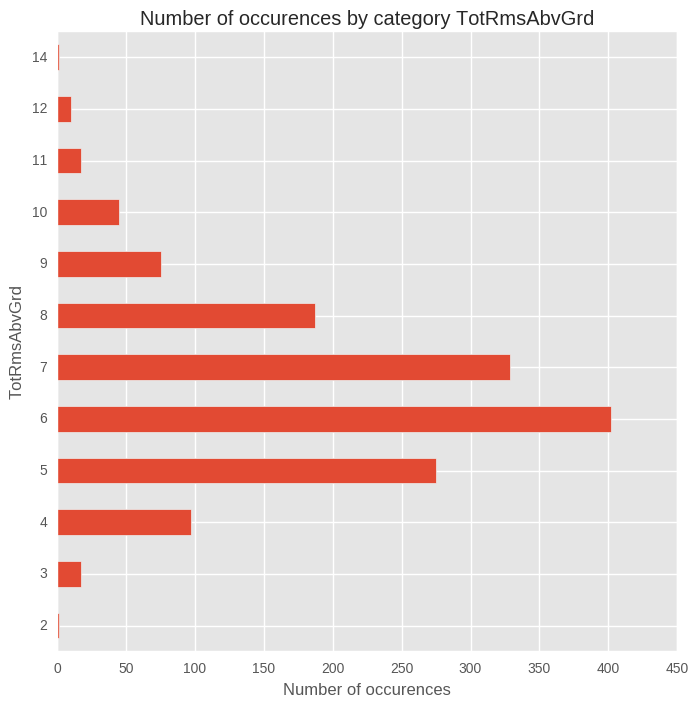

In [19]:
simple_count("TotRmsAbvGrd", (8,8))

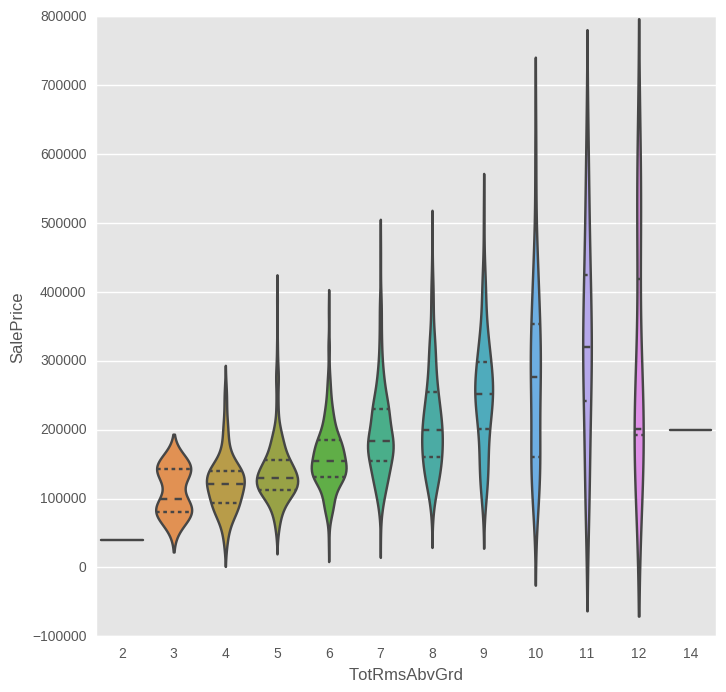

In [20]:
simple_violin("TotRmsAbvGrd", (8,8))

This distribution of the hourses on the total number of rooms above ground is more like Gaussian distribution. We can combine with bathrooms above ground to have a __real__ total number of rooms on the ground. And it could be dropped.

## YearBuilt
As the name indicats, it is the year when the house is built. It looks like it somehow has influences on the price of the house.

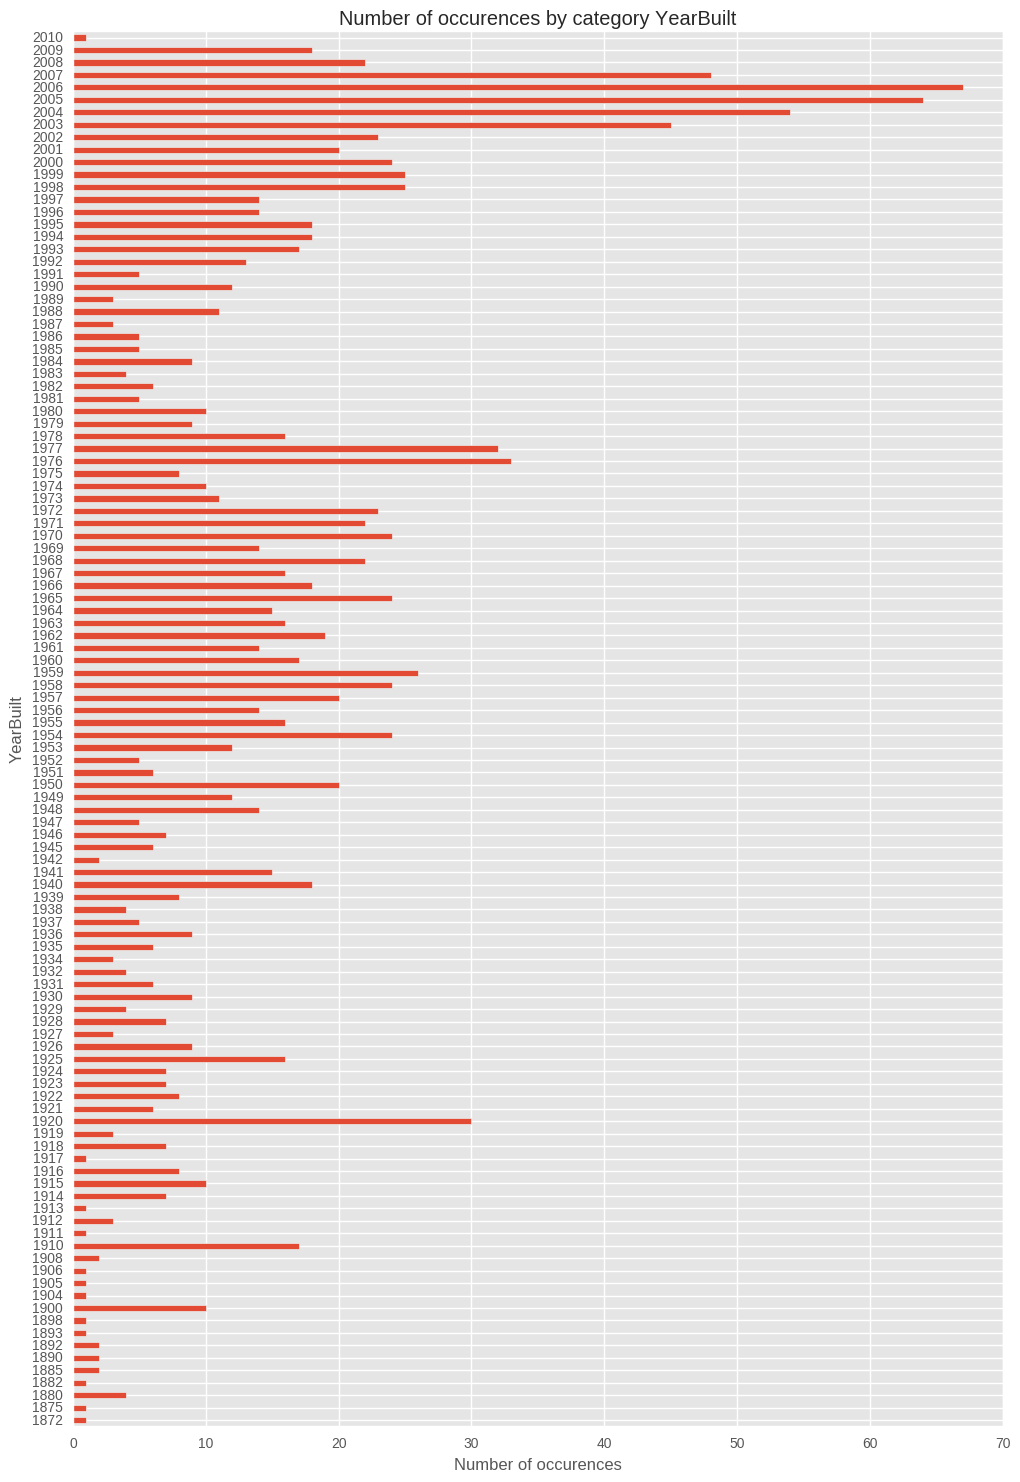

In [21]:
simple_count("YearBuilt", (12,18))

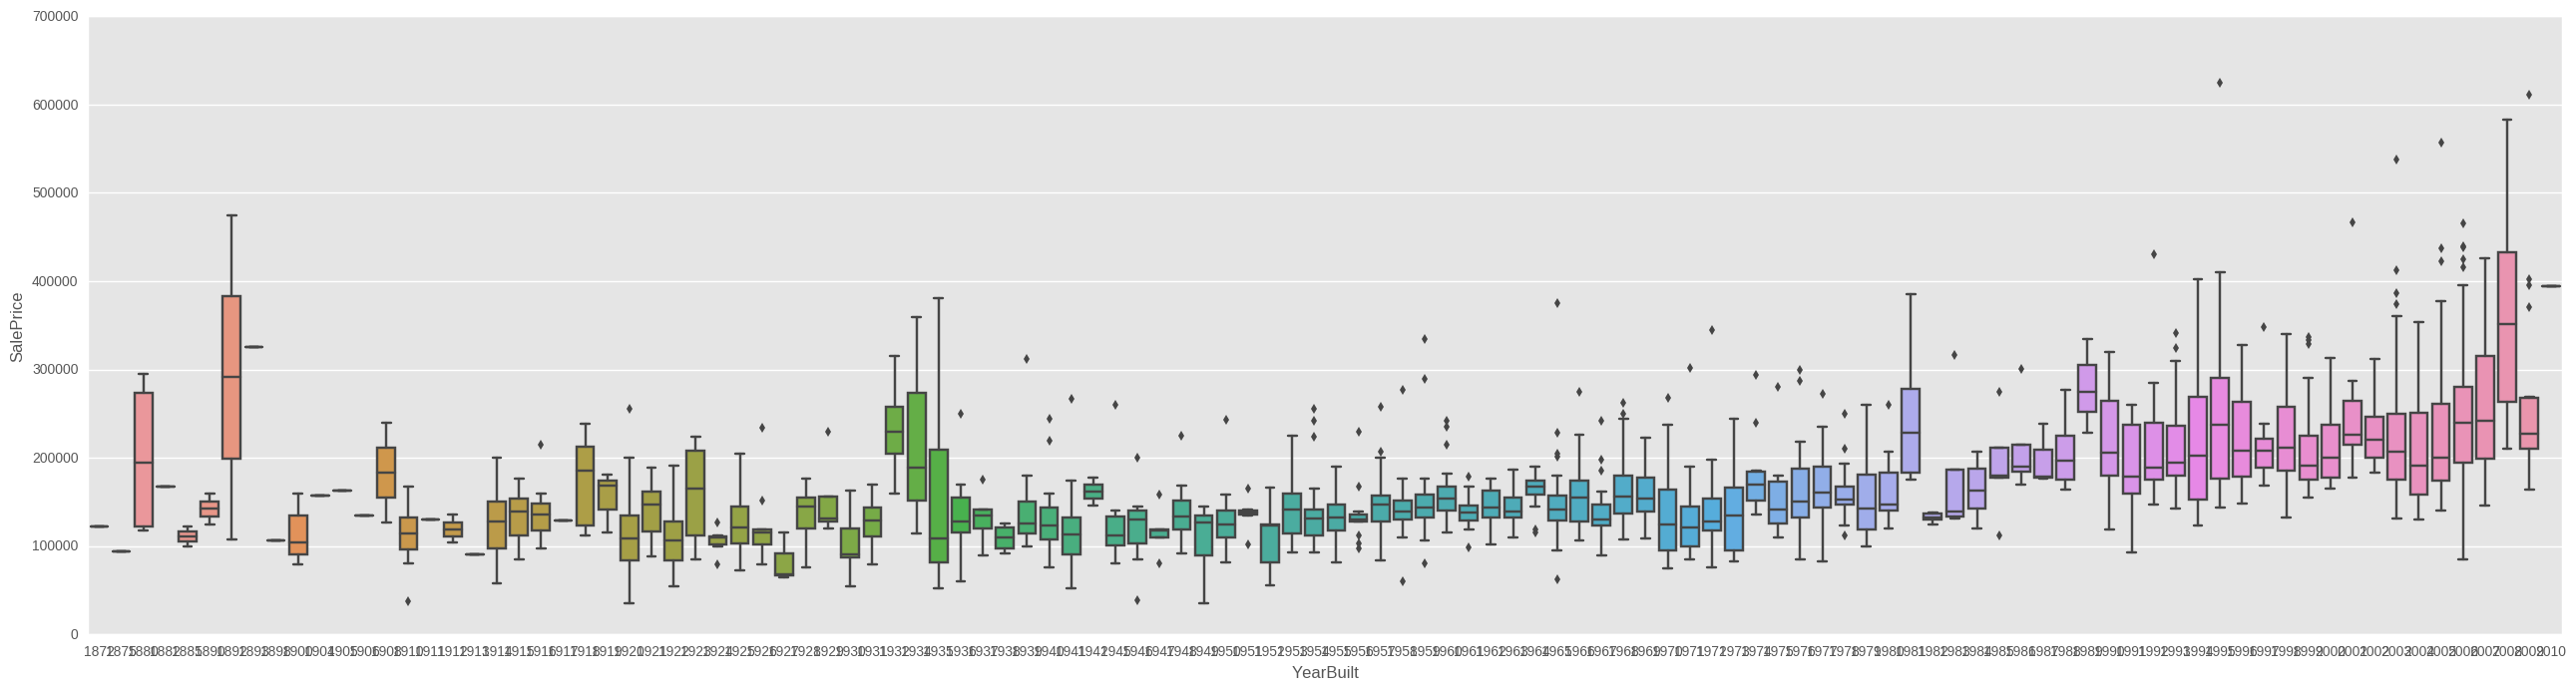

In [22]:
fig = plt.figure(figsize=(32,8))
sns.boxplot(x="YearBuilt", y="SalePrice", data=df_train)

It is an important feature we can keep.

## YearRemodAdd
If the house has been remodeled, this feature will store the year it happened.

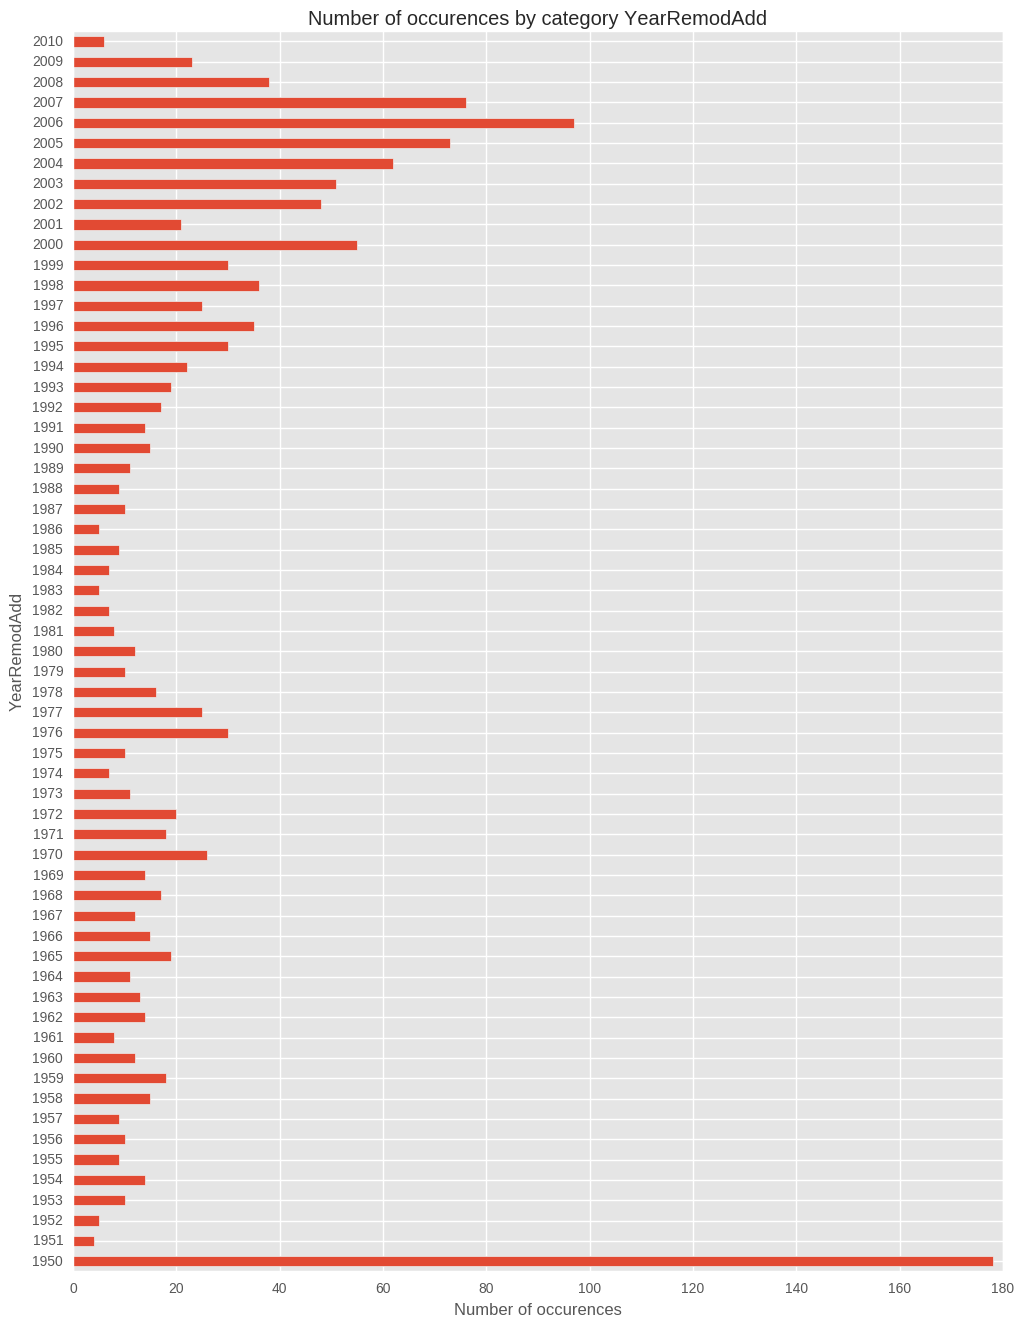

In [23]:
simple_count("YearRemodAdd", (12,16))

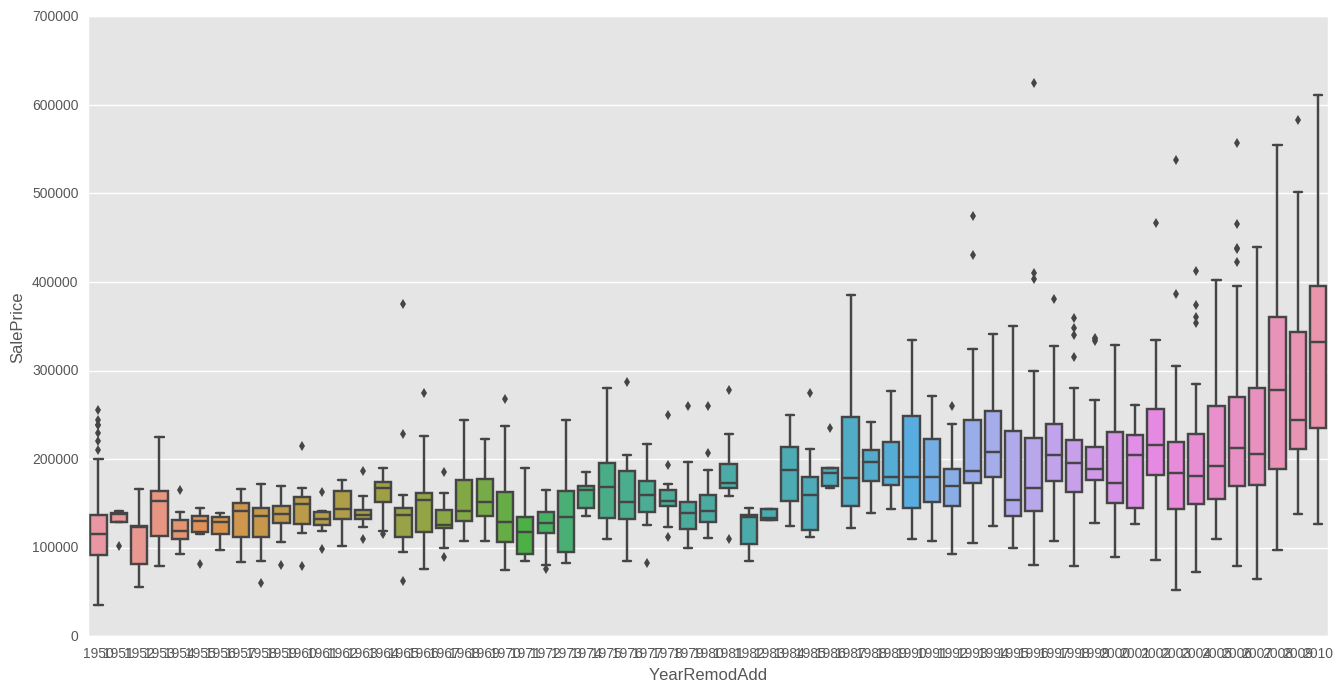

In [24]:
fig = plt.figure(figsize=(16,8))
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=df_train)

It looks like all houses built before 1950 has been remodeled in 1950. We can create a new feature that indicates that it has been remodeled.

## GarageYrBlt
The building year of the garage

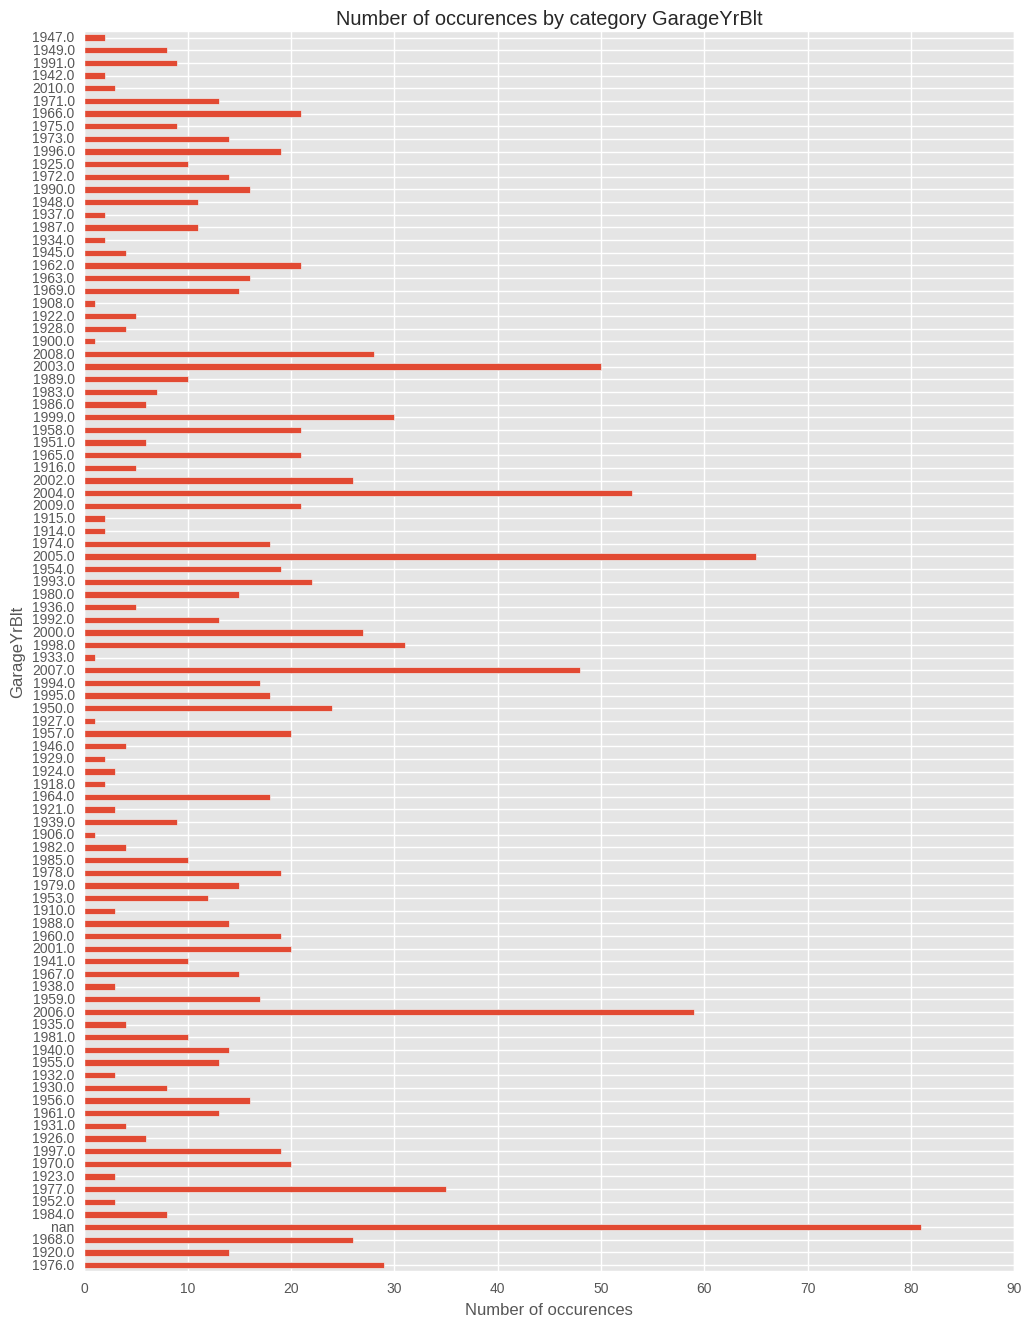

In [25]:
simple_count("GarageYrBlt", (12,16))

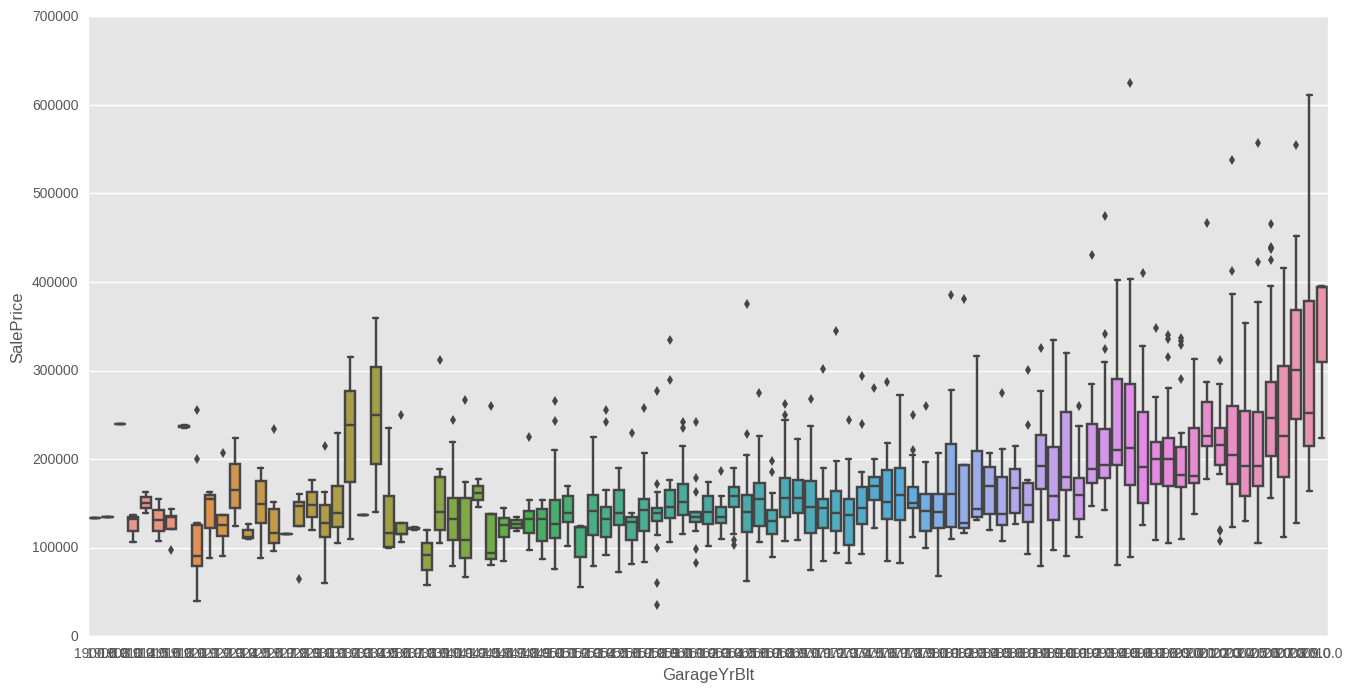

In [26]:
fig = plt.figure(figsize=(16,8))
sns.boxplot(x="GarageYrBlt", y="SalePrice", data=df_train)

There are missing values in this feature, indicating there is no garage in the house. A new feature can be created to indicates if there is a difference between the year Garage built and house built, or there is no garage at all.

## Fireplaces
Number of fireplaces 

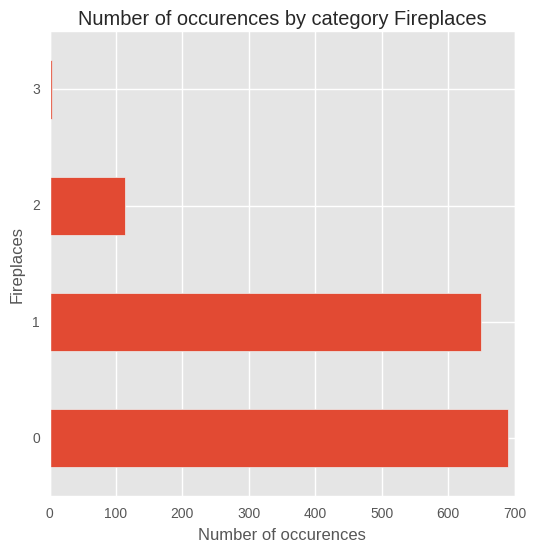

In [27]:
simple_count("Fireplaces", (6,6))

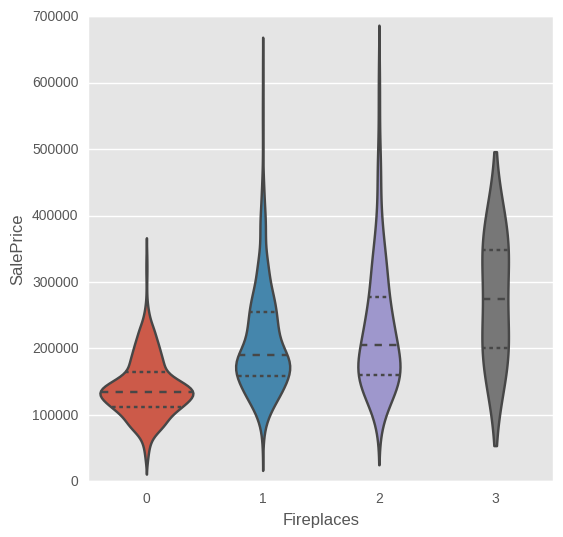

In [28]:
simple_violin("Fireplaces", (6,6))

Even from the distribution of the house price on the number of firepaces, there are not too much difference between different categories. However, most houses have 0 or 1 fireplace, and those prices are quite different. 

In [29]:
cat = df_train.select_dtypes(include=['object'])

In [30]:
cat.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1456,1456,91,1456,1456,1456,1456,1456,1456,1456,...,1375,1375,1375,1375,1456,5,280,54,1456,1456
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1147,1450,50,925,1309,1455,1051,1378,225,1258,...,867,605,1307,1322,1336,2,156,49,1265,1197


In [31]:
qualitative = list(cat.columns)

In [32]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

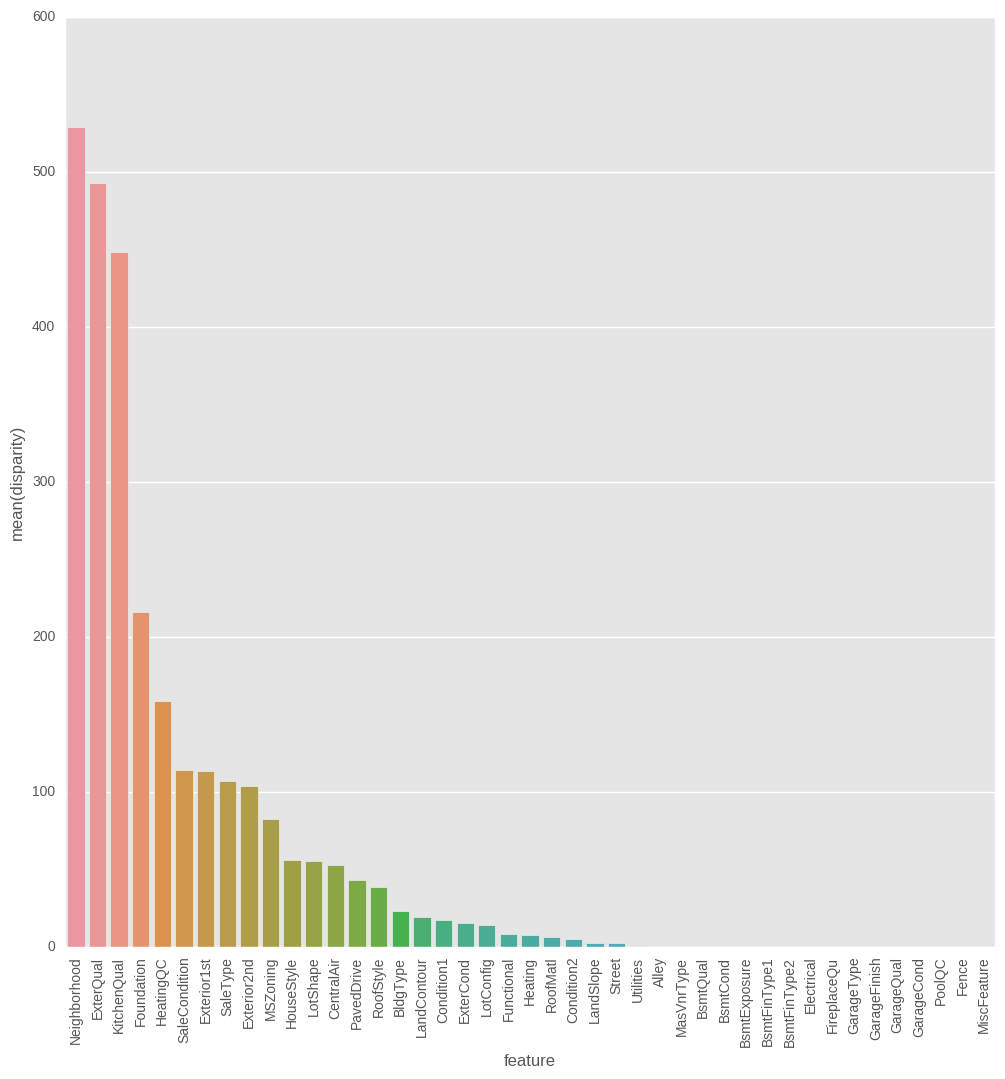

In [33]:
a = anova(df_train)
a["disparity"] = np.log(1./a["pval"].values)
plt.figure(figsize=(12,12))
sns.barplot(data=a, x="feature", y="disparity")
x =plt.xticks(rotation=90)